# Feature Extraction: GLCM

## Setup

In [12]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2 as cv

from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [13]:
sns.set_theme(style="darkgrid")

In [14]:
#paths
root = '.'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/data'

## Load Data

In [15]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [16]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

## View Class Samples

In [17]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])
    
    return sample_images, sample_labels

In [18]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

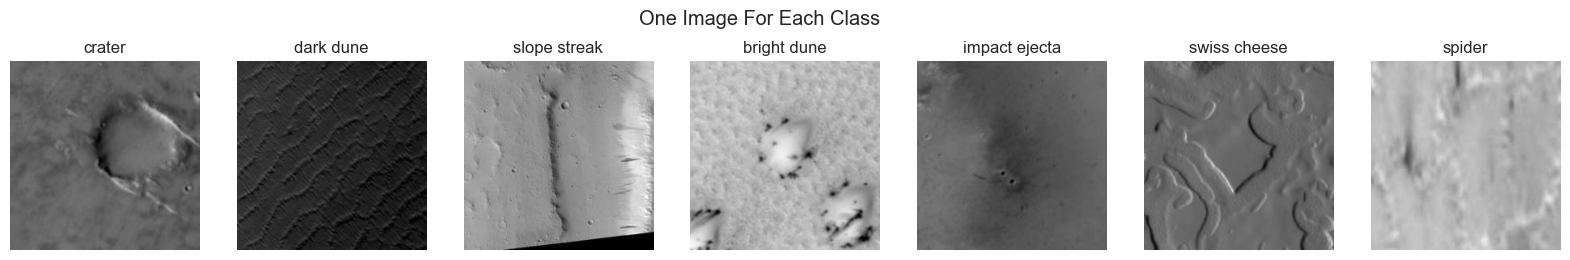

In [19]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: GLCM

In [166]:
def get_glcm_feature(imgs: list, distance, angle) -> tuple:

    """Feature Types: contrast, disimilarity, homogeneity, energy, correlation"""
    feature_types = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    result_fts = []

    #params for GLCM
    distances = [distance]
    angles = [angle]
    
    for img in imgs:
        #img = cv.GaussianBlur(img, (5, 5), 0)
        #img = cv.normalize(img, None, 0, 1, cv.NORM_MINMAX, cv.CV_32F)
        img = img[:,:,0]
        #img = img.astype(int)

        glcm = graycomatrix(img, distances = distances, angles = angles, levels = 256)

        img_features = []
        for type in feature_types:
            result = graycoprops(glcm, f'{type}')
            img_features.append(result)

        result_fts.append(np.array(img_features).flatten())

    return np.array(result_fts)

def plot_glcm_histogram(glcm_feature: list, sample_labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(sample_imgs), figsize=(20,3))

    samples = zip(sample_labels, glcm_feature)

    for i, (label, img) in enumerate(samples):
        ax = axs[i]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('GLCM Feature Type per Class')
    plt.show()

In [ ]:
def plot_glcm_test(glcm_feature, sample_labels):
    samples = zip(sample_labels, glcm_feature)
    sns.distplot(

In [167]:
train_glcm = get_glcm_feature(train_images, distance = 4, angle = np.pi/2)
val_glcm = get_glcm_feature(val_images, distance = 4, angle = np.pi/2)

In [168]:
contrast_features[0]

array([ 7.90185891e-05,  7.90185891e-05,  9.99960491e-01,  9.99920983e-01,
       -3.95108556e-05])

In [169]:
contrast_features.shape

(8960, 5)

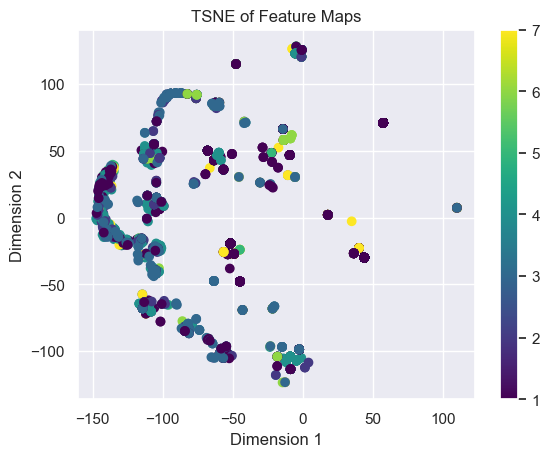

In [170]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(contrast_features)
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(X_scaled)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

In [171]:
clf = LogisticRegression().fit(X_scaled, train_labels)
clf.score(X_scaled, train_labels)

0.41450892857142857

In [172]:
clf.score(val_glcm, val_labels)

0.026066350710900472